In [3]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "seg-brain/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
CLASS_COUNT = 4  



In [ ]:
import os
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.samples = []
        self.transform = transform

        for s in sorted(os.listdir(root_dir)):
            try:
                num = int(s.split("_")[-1])           
                if num > 354:
                    continue  
            except:
                continue  

            base_path = os.path.join(root_dir, s)
            required = [f"{s}_flair.nii", f"{s}_t1.nii", f"{s}_t1ce.nii", f"{s}_t2.nii", f"{s}_seg.nii"]
            if all(os.path.exists(os.path.join(base_path, f)) for f in required):
                self.samples.append(s)  

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        sample_path = os.path.join(self.root_dir, sample_id)

        flair = nib.load(os.path.join(sample_path, sample_id + "_flair.nii")).get_fdata()
        t1 = nib.load(os.path.join(sample_path, sample_id + "_t1.nii")).get_fdata()
        t1ce = nib.load(os.path.join(sample_path, sample_id + "_t1ce.nii")).get_fdata()
        t2 = nib.load(os.path.join(sample_path, sample_id + "_t2.nii")).get_fdata()
        seg = nib.load(os.path.join(sample_path, sample_id + "_seg.nii")).get_fdata()

        slice_idx = 80
        image = np.stack([flair[:, :, slice_idx], t1[:, :, slice_idx],
                          t1ce[:, :, slice_idx], t2[:, :, slice_idx]], axis=0)
        mask = seg[:, :, slice_idx].astype(np.int64)
        mask[mask == 4] = 3  

        image = (image - image.mean()) / image.std()
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask


In [5]:
model = smp.Unet(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=4,                  
    classes=CLASS_COUNT,            
).to(DEVICE)


c:\Users\ALIREZA\codes\brain-tumor-seg\segenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ALIREZA\.cache\huggingface\hub\models--smp-hub--resnet34.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def multiclass_dice_score(outputs, targets, epsilon=1e-6):
 
    num_classes = outputs.shape[1]
    targets_one_hot = F.one_hot(targets, num_classes).permute(0,3,1,2).float()

    outputs = F.softmax(outputs, dim=1)

    intersection = torch.sum(outputs * targets_one_hot, dim=(2,3))
    cardinality = torch.sum(outputs + targets_one_hot, dim=(2,3))

    dice_score = (2. * intersection + epsilon) / (cardinality + epsilon)

    return dice_score.mean()  

def train(model, loader, optimizer, criterion, epochs=5):
    loss_history = []
    dice_history = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_dice = 0

        for images, masks in loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            dice = multiclass_dice_score(outputs, masks)
            epoch_dice += dice.item()

        avg_loss = epoch_loss / len(loader)
        avg_dice = epoch_dice / len(loader)

        loss_history.append(avg_loss)
        dice_history.append(avg_dice)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Dice Score: {avg_dice:.4f}")

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(range(1, epochs+1), loss_history, 'r-', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, epochs+1), dice_history, 'b-', label='Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Training Dice Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
"""def visualize(model, dataset, idx=0):
    model.eval()
    image, mask = dataset[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(DEVICE))
        pred = torch.argmax(pred.squeeze(), dim=0).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[0], cmap='gray')
    axs[0].set_title('FLAIR')
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Prediction')
    plt.tight_layout()
    plt.show()"""
def visualize_multiple(model, dataset, count=15):
    model.eval()
    fig, axs = plt.subplots(count, 3, figsize=(12, 4 * count))

    for i in range(count):
        image, mask = dataset[i]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(DEVICE))
            pred = torch.argmax(pred.squeeze(), dim=0).cpu()

        axs[i, 0].imshow(image[0], cmap='gray')
        axs[i, 0].set_title(f'Sample {i} - FLAIR')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 1].set_title('Ground Truth')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(pred, cmap='gray')
        axs[i, 2].set_title('Prediction')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


Epoch 1/20, Loss: 0.1562, Dice Score: 0.6325
Epoch 2/20, Loss: 0.1484, Dice Score: 0.6369
Epoch 3/20, Loss: 0.1388, Dice Score: 0.6439
Epoch 4/20, Loss: 0.1464, Dice Score: 0.6397
Epoch 5/20, Loss: 0.1464, Dice Score: 0.6426
Epoch 6/20, Loss: 0.1475, Dice Score: 0.6448
Epoch 7/20, Loss: 0.1342, Dice Score: 0.6494
Epoch 8/20, Loss: 0.1290, Dice Score: 0.6541
Epoch 9/20, Loss: 0.1301, Dice Score: 0.6527
Epoch 10/20, Loss: 0.1393, Dice Score: 0.6485
Epoch 11/20, Loss: 0.1282, Dice Score: 0.6510
Epoch 12/20, Loss: 0.1439, Dice Score: 0.6468
Epoch 13/20, Loss: 0.1299, Dice Score: 0.6541
Epoch 14/20, Loss: 0.1212, Dice Score: 0.6603
Epoch 15/20, Loss: 0.1120, Dice Score: 0.6633
Epoch 16/20, Loss: 0.1251, Dice Score: 0.6581
Epoch 17/20, Loss: 0.1190, Dice Score: 0.6601
Epoch 18/20, Loss: 0.1164, Dice Score: 0.6626
Epoch 19/20, Loss: 0.1193, Dice Score: 0.6599
Epoch 20/20, Loss: 0.1223, Dice Score: 0.6585


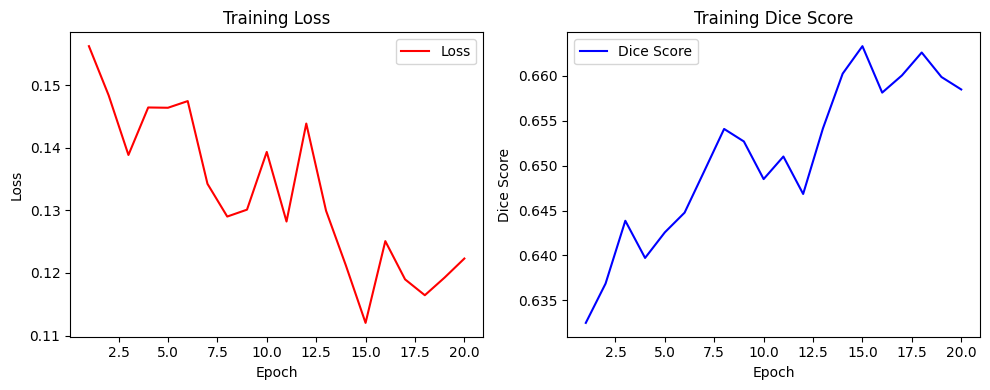

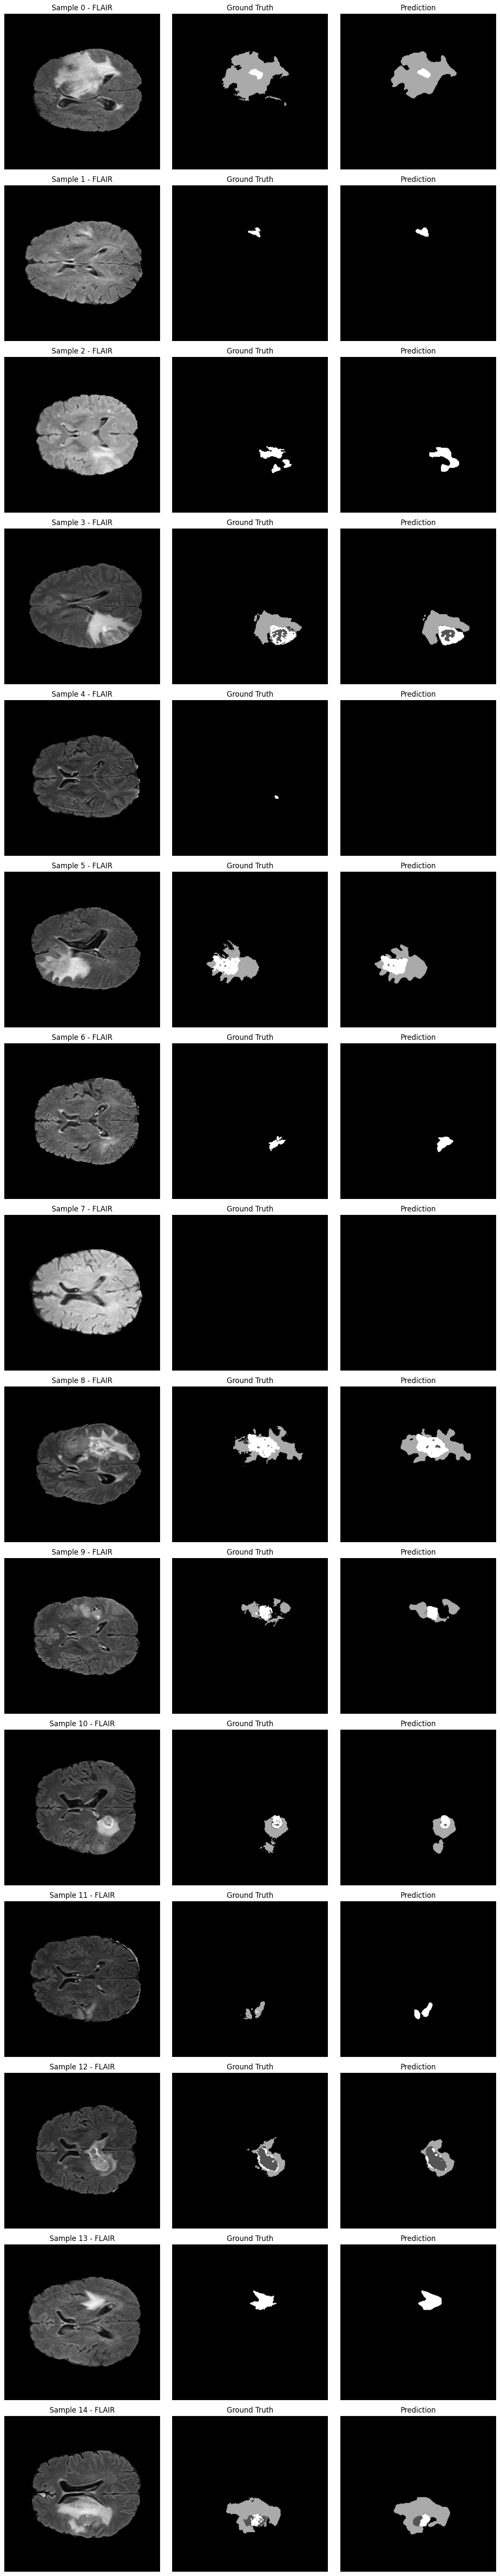

In [10]:
if __name__ == "__main__":
    dataset = BraTSDataset(DATA_DIR)
    loader = DataLoader(dataset, batch_size=2, shuffle=True)

    criterion = smp.losses.DiceLoss(mode='multiclass')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train(model, loader, optimizer, criterion, epochs=20)
    visualize_multiple(model, dataset, count=15)
